In [56]:
#!/usr/bin/python

'''
A program for analysing Mach-Zehnder interferometer measurements and extracting laser linewidths
A. J. McCulloch, September 2019
'''

####################################################################################################
# Import modules
####################################################################################################
import numpy as np
import os
import glob
import csv
from cycler import cycler
from csv import reader
from matplotlib import pyplot as plt
from scipy import integrate
from scipy.optimize import curve_fit, leastsq

####################################################################################################
# Define classes
####################################################################################################

####################################################################################################
# MOGTrace class for trace files from the mognoise evaluation board (Analogue Devices AD7760 ADC)
class MOGTrace():
    def __init__(self, filename):
        self.metadata = []
        self.name = filename

        x = []
        y = []
        item = []

        read = reader(open(filename, "r"), delimiter=",")

        for line in read:
            try:
                float(line[0])
            except ValueError:
                # If the first element of a line is a #, it is metadata
                if line[0][0] == '#':
                    # Clean the metadata
                    for i in line:
                        if i[0] == '#':
                            i = i.replace('#','')
                        i = i.strip()
                        item.append(i)
                else:
                    raise Exception("Something is wrong with the MOGtrace formatting.")

                self.metadata = item
            else:
                # The first item is a number

                # We've reached the data.
                try:
                    x.append(float(line[0]))
                except ValueError:
                    # Sometimes we have Euro numbers with , instead of .
                    x.append(float(line[0].replace(',', '.')))

                try:
                    y.append(float(line[1]))
                except ValueError:
                    # Sometimes we have Euro numbers with , instead of .
                    y.append(float(line[1].replace(',', '.')))

        self.x = np.array(x)
        self.y = np.array(y)

####################################################################################################
# Reset the directory (useful when altering code)
def resetdir():
    os.chdir('C:\\Users\\Andy\\Dropbox\\AndyDOCS-work\\Lasers\\Linewidth measurement\\Mach-Zehnder')
    print("Current working directory reset to " + os.getcwd())
    
####################################################################################################
# Returns a plot of trace
# To subtract a background, include a second trace file to be subtracted
def traceplot(trace, background = None, savefig = False):
    
    fig, ax = plt.subplots() # Initialise figure and axes
    
    ax.plot(trace.x, trace.y, linestyle = '-', linewidth = 1, alpha = .33, label = 'Signal') # Plot the trace
    
    # Subtract a backgound
    if background != None:
        yvals = trace.y - background.y + np.median(background.y)
        ax.plot(background.x, background.y, linestyle = '-', linewidth = 1, alpha = .33, label = 'Background') # Plot the trace
        ax.plot(trace.x, yvals, linestyle = '-', linewidth = 1.5, alpha = 1, label = 'Subtracted') # Plot the trace
        plt.legend(fontsize=16) # Include a plot legend
    
    # Plot parameters
    plt.xlim((trace.x[0], trace.x[-1])) # Set the plot limits
    plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
    

    plt.grid(which = 'major') # Include major gridlines
    plt.grid(which = 'minor', linewidth = .1, alpha = 1) # Include minor gridlines

    plt.title('Demodulated Mach-Zehnder beatnote', fontsize=32) # Set the figure title
    plt.xlabel('Frequency [Hz]', fontsize=24) # Set the x-axis label
    plt.ylabel('Power spectral density [dBm/Hz]', fontsize=24) # Set the y-axis label
    plt.xticks(size = 18) # Set the size of the x-axis markers
    plt.yticks(size = 18) # Set the size of the y-axis markers
    plt.xscale('log') # Make the x axis logrithmically scaled
    
    # Save the figure
    if savefig == True:
        plt.savefig('output.pdf', bbox_inches='tight') # Save a .pdf of the figure

    plt.show() # Show the figure

####################################################################################################
# Returns the area under a curve specified at points (x,y) between x = lower and x = upper
def retrunarea(x, y, lower, upper):
    # Set upper and lower limits for integration
    x_low = lower
    x_high = upper
    x_vals = x[(x > x_low ) & (x < x_high)] # Select x values between the limits
    # Return the indexes for the array to integrate
    findindex = lambda i: [int(np.where(i == x_vals[0])[0]), int(np.where(i == x_vals[-1])[0]) + 1]
    totake = findindex(x)

    area = integrate.simps(y[totake[0]:totake[1]], x_vals) # Integrate using Simpson's rule within the bounds
    
    return area    
    
####################################################################################################
# Returns the V_rms value calculated from the area under the PSD curve between frequencies lowerbound and upperbound
def getVrms(trace, lowerbound, upperbound, doplot = False):
    # Convert PSD in dBm/Hz to V_rms^2/Hz
    dbmtov = lambda p: (50 * 1e-3)*(10 ** (p/10))
    # Power spectral density (in V_rms^2/Hz)
    psd = dbmtov(trace.y)

    if doplot == True:
        # Set the plot parameters
        plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
        plt.title("Demodulated Mach-Zehnder beatnote", fontsize=32) # Set the figure title
        plt.xlabel("Frequency [Hz]", fontsize=24) # Set the x-axis label
        plt.ylabel("Power spectral density [$mV^2$/Hz]", fontsize=24) # Set the y-axis label
        plt.xticks(size = 18) # Set the size of the x-axis markers
        plt.yticks(size = 18) # Set the size of the y-axis markers

        plt.plot(trace.x, dbmtov(trace.y)/1e-6, linewidth = 2, alpha = .75)
        plt.xscale('log')
        
    # Set upper and lower limits for integration
    f_low = lowerbound
    f_high = upperbound
    f_vals = trace.x[(trace.x > f_low ) & (trace.x < f_high)] # Select frequency values inbetween the limits
    # Return the indexes for the array to integrate
    findindex = lambda x: [int(np.where(x == f_vals[0])[0]), int(np.where(x == f_vals[-1])[0]) + 1]
    totake = findindex(trace.x)
    # Integrate the PSD
    area = integrate.simps(psd[totake[0]:totake[1]], f_vals) # Integrate the PSD within the bounds
    vrms = np.sqrt(area) # Take the square root of the result
    
    return vrms

####################################################################################################
# Returns the calibration factor to convert from voltage to frequency
def returncalib(trace, reffreq = 30, FSR = 20e6):
    x0 = reffreq # Reference signal location [Hz]
    xc = trace.x[np.abs(trace.x-x0).argmin()] # Find the closest x value to x0
    xci = np.where(trace.x == xc)[0][0] # Return the index of closest location
    xci0 = xci # Store this original value

    # Need to check if there are greater values nearby (x \pm delta)
    if trace.y[xci+1] > trace.y[xci]: # See if the index + 1 is a greater value
        xci += 1
        while True: # Keep going until you find the maximum
            if trace.y[xci+1] > trace.y[xci]:
                xci += 1
            else:
                break
    elif trace.y[xci-1] > trace.y[xci]:  # See if the index - 1 is a greater value
        xci -= 1
        while True:
            if trace.y[xci-1] > trace.y[xci]:  # Keep going until you find the maximum
                xci -= 1
            else:
                break

    if abs(xci - xci0) <= 5: # Make sure that we have not gone too far, the peak should be where we expect!
        yc = trace.y[xci] # Calibration power
    else:
        print("Invalid spectrum. No clear peak found around " + str(x0) + " Hz")
    
    dBmtoVRMS = lambda p: np.sqrt((50 * 1e-3)*(10 ** (p/10)))
    cal = 2 * np.pi * (dBmtoVRMS(yc)/FSR)
    
    return 1/cal 

####################################################################################################
# Returns the RMS value of the linewidth calculated from the area under the PSD curve between the frequencies lowerbound and upperbound
def getlinewidthRMS(trace, lowerbound, upperbound, doplot = False):
    RBW = 2.5e6/2097152 # Resolution bandwidth from ADC
    impedance = 50 # Electrical impedance for calculating voltage from power
    calibration = returncalib(trace)
    dbmtoW = lambda p: (1e-3)*(10 ** (p/10)) # Convert power from dBm to Watts

    WperHz = dbmtoW(trace.y)/RBW # Power per Hertz
    VperrtHz = np.sqrt(impedance * WperHz) # Voltage per Root Hertz
    LSD = VperrtHz * calibration # Linear spectral density [Hz/Hz^1/2]
    trace.PSD = LSD ** 2 # Power spectral density [Hz^2/Hz]

    linewidthRMS = np.sqrt(retrunarea(trace.x, trace.PSD, lowerbound, upperbound))

    if doplot == True:
        # Set the plot parameters
        plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
        plt.title("Demodulated Mach-Zehnder beatnote", fontsize=32) # Set the figure title
        plt.xlabel("Frequency [Hz]", fontsize=24) # Set the x-axis label
        plt.ylabel("Power spectral density [Hz$^2$/Hz]", fontsize=24) # Set the y-axis label
        plt.xticks(size = 18) # Set the size of the x-axis markers
        plt.yticks(size = 18) # Set the size of the y-axis markers

        plt.grid(which = 'major') # Include major gridlines
        plt.grid(which = 'minor', linewidth = .1, alpha = 1) # Include minor gridlines

        plt.plot(trace.x, trace.PSD, linewidth = 2, alpha = .75)
        plt.xscale('log')
        plt.yscale('log')
    
    return calibration, linewidthRMS

####################################################################################################
# The runner function for the analysis of the Mach-Zehnder interferometre beatnote
# The folder input should be the directory of the files to analyse
# The method input must be either 'PSD' or 'VRMS'
def MZIrunner(folder, method):
    cwd = os.getcwd() # Current working directoy
    # If you look at a .pdf and run this again, you will get a permissions error; however the cwd should always be reset
    try:
        # Need to check if the folder input is a full directory or just folder
        if max(folder.count('/'),folder.count('\\')) >= cwd.count('\\'): # This means 'folder' is a full directory
            newdir = folder
        else: # Use 'folder' as a subdirectory
            newdir = cwd + '\\' + folder # Working directory for scans

        os.chdir(newdir) # Set the working directy to the new directory
        spectra = glob.glob('*binned.csv') # Find .csv files in the specified folder

        # Make a plot of PSD
        fig, ax = plt.subplots() # Initialise figure and axes

        # Initialise the list of results
        file = []
        cal_res = []
        lw_res = []
    
        if method == 'PSD':
            # Initialise the list of method specific results
            ylabeltext = 'Power spectral density [Hz$^2$/Hz]'
            yscale = 'log'
            outtitle = '_Hz2'
            
            # Loop over spectra
            for spec in spectra:
                trace = MOGTrace(spec) # Import the traces
                
                if spec[:-10].lower() != 'background':
                    cal, lw = getlinewidthRMS(trace, 50, 1e5)  # Calculate the calibration factor linewidth
                    
                    file.append(spec[:-10]) # Laser name
                    cal_res.append(cal) # Store the calibration value
                    lw_res.append(lw) # Store the calculated linewidth
               
                    ax.plot(trace.x, trace.PSD, linestyle = '-', linewidth = 1, alpha = .75, label = spec[:-10]) # Plot the traces
                    print('Laser linewidth of {:s} determined to be {:.2f} kHz. The frequency to voltage calibration was {:2f} kHz/V \n'.format(file[-1], lw_res[-1]/1e3, cal_res[-1]/1e3))
                      
            # PSD results
            header = ['File', 'Calibration [Hz/V]', 'linewidth [Hz]'] # Header for output
            output = [header] + np.transpose([file, cal_res, lw_res]).tolist() # Output cotent formatted for .csv
     
        elif method == 'VRMS':
            
            # Initialise the list of method specific results
            vRMSlw_res = []
            FSR = 20e6 # Free spectral range of the fibre
            ylabeltext = 'Power spectral density [dBm/Hz]'
            yscale = 'linear'
            outtitle = '_dBm'
            
            # Loop over spectra
            for spec in spectra:
                trace = MOGTrace(spec) # Import the traces
                
                ax.plot(trace.x, trace.y, linestyle = '-', linewidth = 1, alpha = .75, label = spec[:-10]) # Plot the traces
                      
                if spec[:-10].lower() != 'background':
                    vc = getVrms(trace, 25, 35) # Get the value of V_rms for the 30 Hz peak
                    vl = getVrms(trace, 50, 1e5) # Get the value of V_rms up to 100 kHz

                    file.append(spec[:-10]) # Laser name
                    cal_res.append(vc) # Get the value of V_rms for the 30 Hz peak
                    vRMSlw_res.append(vl) # Get the value of V_rms up to 100 kHz
                    lwidth = lambda r: r * FSR/(2 * np.pi) # Calculate the linewidth from the ratio of voltages
                    lw_res.append(lwidth(vl/vc))

                    print('Laser linewidth of {:s} determined to be {:.2f} kHz. \nRMS values of voltage were {:.2f} and {:.2f} mV @ 30 Hz and up to 100 kHz respectively\n'.format(file[-1], lw_res[-1]/1e3, cal_res[-1]/1e-3, vRMSlw_res[-1]/1e-3))
        
            # V_RMS results
            header = ['File', 'V_RMS (30 Hz)', ' V_RMS (linewidth)', 'linewidth'] # Header for output
            output = [header] + np.transpose([file, cal_res, vRMSlw_res, lw_res]).tolist() # Output cotent formatted for .csv
        
        else:
            print('Method is invalid')
                      
        # Export list of summary results
        with open('Summary'+outtitle+'.csv', "w", newline="") as f:
            writer = csv.writer(f)
            writer.writerows(output)

        # Plot parameters
        plt.xlim((trace.x[0], trace.x[-1])) # Set the plot limits
        plt.rcParams['figure.figsize'] = [12, 9] # Set figure size
        plt.legend(fontsize=16) # Include a plot legend

        plt.grid(which = 'major') # Include major gridlines
        plt.grid(which = 'minor', linewidth = .1, alpha = 1) # Include minor gridlines

        plt.title('Demodulated Mach-Zehnder beatnote', fontsize=32) # Set the figure title
        plt.xlabel('Frequency [Hz]', fontsize=24) # Set the x-axis label
        plt.ylabel(ylabeltext, fontsize=24) # Set the y-axis label
        plt.xticks(size = 18) # Set the size of the x-axis markers
        plt.yticks(size = 18) # Set the size of the y-axis markers
        plt.xscale('log') # Make the x axis logrithmically scaled
        plt.yscale(yscale) # Scale the y axis appropriately

        plt.savefig('PSD'+outtitle+'.pdf', bbox_inches='tight') # Save a .pdf of the figure

        plt.show() # Show the figure

        os.chdir(cwd) # Reset the working directory

    except PermissionError:
        Print('Close any .pdf files you have open')
        os.chdir(cwd) # Set the working directory to the original directory

# Example usage

Plot a Mach-Zehnder beatnote spectrum, with optional background subtraction (relative to the median of the background)

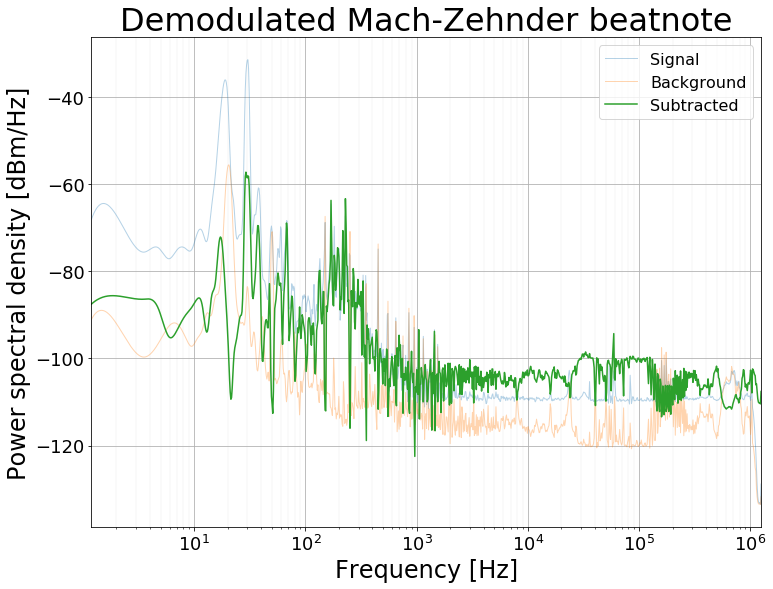

In [47]:
fileloc = 'Data\\20190910_markzehender' # Directory containing files

specfile = 'laser1binned.csv' # Spectrum file
bkgndfile = 'backgroundbinned.csv' # Background file

# Function to make appropiate strings
concat = lambda s: fileloc + '\\' + s

spec = MOGTrace(concat(specfile)) # Spectrum trace
bkgnd = MOGTrace(concat(bkgndfile)) # Background trace

traceplot(spec, bkgnd)

Analyse the Mach-Zehnder beatnote spectra

Laser linewidth of laser1 determined to be 220.33 kHz. 
RMS values of voltage were 7.97 and 0.55 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of laser2 determined to be 218.50 kHz. 
RMS values of voltage were 14.24 and 0.98 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of laser3 determined to be 192.09 kHz. 
RMS values of voltage were 11.52 and 0.70 mV @ 30 Hz and up to 100 kHz respectively



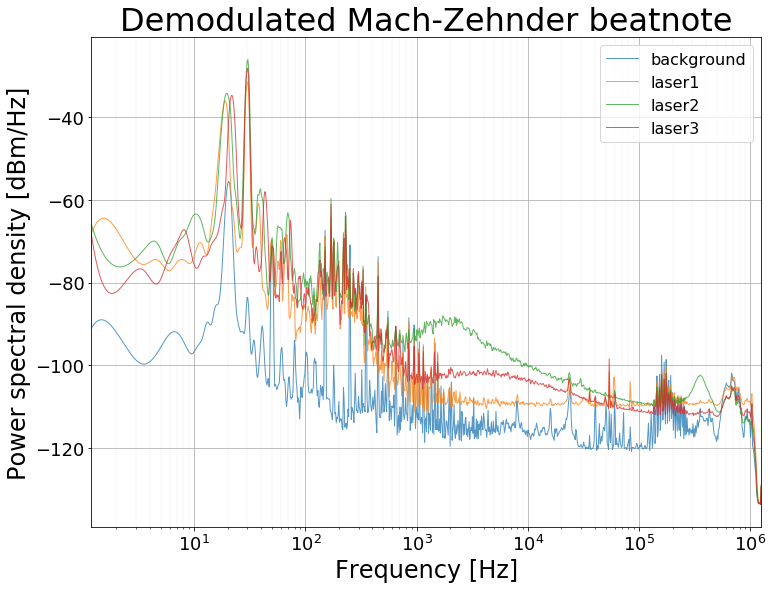

In [57]:
MZIrunner('Data\\20190910_markzehender', 'VRMS')

# Usage for data analysis

Laser linewidth of Laser1 determined to be 469.72 kHz. 
RMS values of voltage were 367.83 and 54.28 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of Laser2 determined to be 486.29 kHz. 
RMS values of voltage were 366.22 and 55.95 mV @ 30 Hz and up to 100 kHz respectively

Laser linewidth of Laser3 determined to be 462.18 kHz. 
RMS values of voltage were 369.71 and 53.68 mV @ 30 Hz and up to 100 kHz respectively



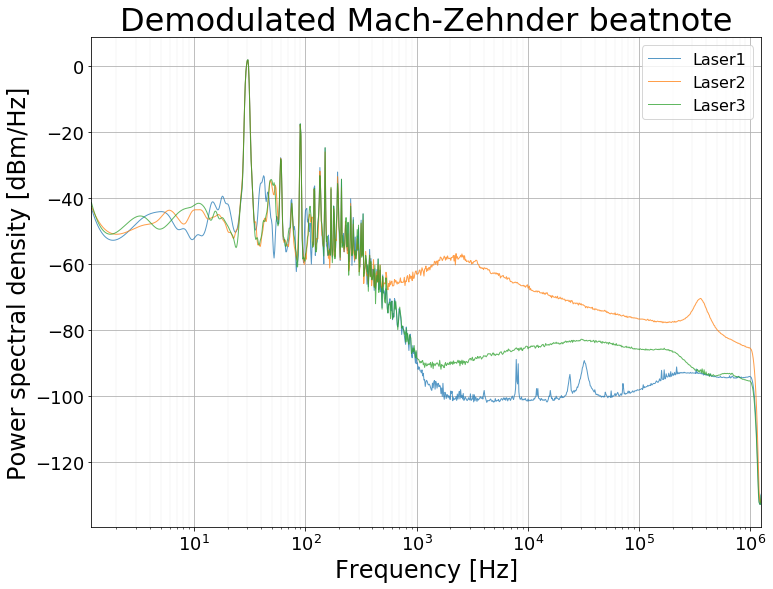

In [58]:
MZIrunner('Data\\20190918_Mach-Zehnder\\Set2', 'VRMS')

Laser linewidth of Laser1 determined to be 561.50 kHz. The frequency to voltage calibration was 11294.293650 kHz/V 

Laser linewidth of Laser2 determined to be 582.56 kHz. The frequency to voltage calibration was 11368.632430 kHz/V 

Laser linewidth of Laser3 determined to be 552.20 kHz. The frequency to voltage calibration was 11231.237863 kHz/V 



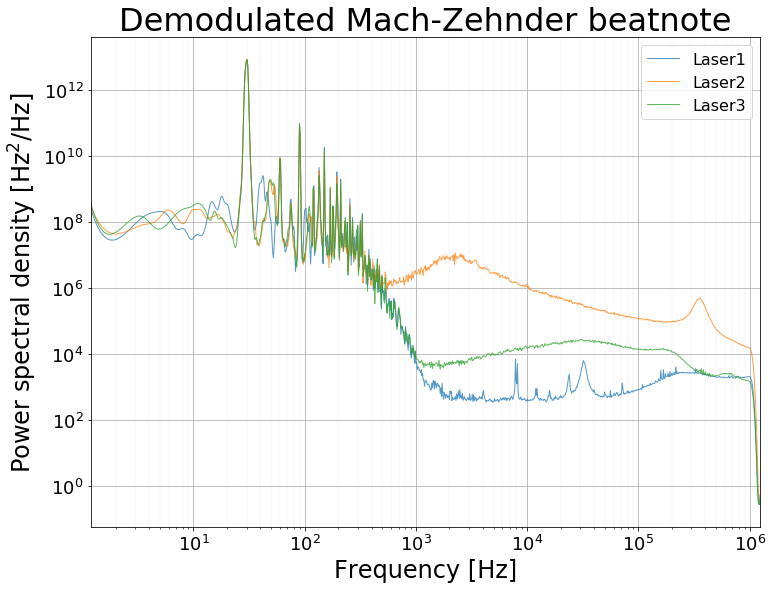

In [59]:
MZIrunner('Data\\20190918_Mach-Zehnder\\Set2', 'PSD')

Laser linewidth of Laser1 determined to be 169.56 kHz. The frequency to voltage calibration was 309431.394924 kHz/V 

Laser linewidth of Laser2 determined to be 237.72 kHz. The frequency to voltage calibration was 309194.368376 kHz/V 

Laser linewidth of Laser3 determined to be 186.61 kHz. The frequency to voltage calibration was 311064.840026 kHz/V 



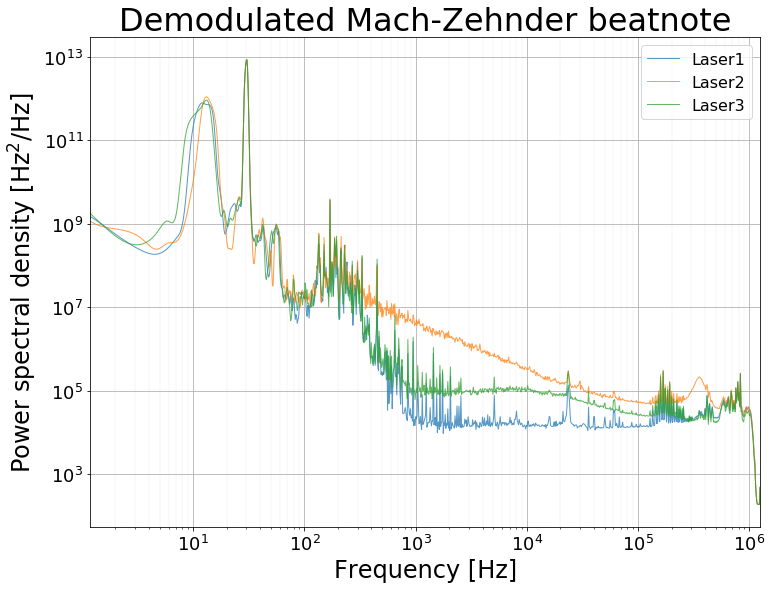

In [45]:
MZIrunner('Data\\20190916_Mach-Zehnder\\Set 2 (same power)','PSD')